In [450]:
import sys
import os
import glob
from skimage import io
from matplotlib import pyplot as plt
from skimage.transform import resize, rotate
from skimage import color
from skimage.morphology import closing, opening, disk, square
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
import math 
import numpy as np
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.filters import threshold_otsu

# tymczasowe importy do testów
from skimage.measure import find_contours, approximate_polygon, regionprops, label
from skimage.color import label2rgb
from skimage.draw import circle_perimeter, rectangle_perimeter, circle, line
from matplotlib import cm

In [451]:
# do wersji v1
def get_line_length(point1, point2):
    return math.pow((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 , 0.5)
def get_angle_of_line(line):
    (point1, point2) = line
    angle = math.atan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi
    return angle #if angle >= 0 else 180+angle

def get_angle_to_rotate_image(image):
    thresh = threshold_otsu(image)
    image_binary = image > thresh
    edges = canny(image_binary, sigma=1, low_threshold=False, high_threshold=True)
    min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
    lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/3),
                                     line_gap=10)

    counter_of_tries = 0
    while lines == 0 and counter_of_tries < 3:
        edges = canny(image_binary, sigma=1, low_threshold=False, high_threshold=True)
        min_length = image.shape[0] if image.shape[0] >= image.shape[1] else image.shape[1]
        lines = probabilistic_hough_line(edges, threshold=10, line_length=int(min_length/3),
                                         line_gap=10)

    longest_line = (lines[0],  get_line_length(lines[0][0], lines[0][1]))
    for line in lines:
        temp_lenght = get_line_length(line[0], line[1])
        if temp_lenght > longest_line[1]:
            longest_line = (line, temp_lenght)

    angle = get_angle_of_line(longest_line[0])
    baseline = longest_line[0]
    return angle, baseline

def compare_2_numbers_with_range(n1, n2, range=3):
    difference = abs(n1-n2)
    return difference <= range
compare_2_numbers_with_range(5.40, 3.10, 3)

def compare_2_points_with_range(point1, point2, range=3):
    x1, y1 = point1
    x2, y2 = point2
    return compare_2_numbers_with_range(x1, x2, range) and compare_2_numbers_with_range(y1, y2, range)
compare_2_points_with_range((10,20), (8,27), 5)

False

In [7]:
def check_if_perpendicular_lines(line1, line2, accuracy_in_degrees=10):
    point11, point12 = line1
    point21, point22 = line2
    if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
        angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
        if compare_2_numbers_with_range(angle_between_lines, 90, accuracy_in_degrees) or compare_2_numbers_with_range(angle_between_lines, 270, accuracy_in_degrees):
            return True
    return False

# def check_if_parallel_lines(line1, line2, accuracy_in_degrees=10):
#     point11, point12 = line1
#     point21, point22 = line2
#     if compare_2_points_with_range(point11, point21, 10) or compare_2_points_with_range(point11, point22, 10) or compare_2_points_with_range(point12, point21, 10):     
#         angle_between_lines = abs(get_angle_of_line(line1)-get_angle_of_line(line2))
#         if compare_2_numbers_with_range(angle_between_lines, 0, accuracy_in_degrees) or compare_2_numbers_with_range(angle_between_lines, 360, accuracy_in_degrees):
#             return True  
#     return False


In [705]:
# do wersji v3 - szukanie punktów skrajnych
# def get_extreme_points(image):
#     possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
#     minHeight = image.shape[0]-1
#     maxHeight = 0 
#     minWidth = image.shape[1]-1 
#     maxWidth = 0 
#     for height, width in possible_baseline_points:
#         if height <= minHeight:
#             minHeight = height
#         if width <= minWidth:
#             minWidth = width
            
#         if height >= maxHeight:
#             maxHeight = height
#         if width >= maxWidth:
#             maxWidth = width
            
#     extreme_points = set()
#     image = color.grey2rgb(image)
#     for height, width in detected_points:  
#         if height == minHeight or height == maxHeight or width == minWidth or width == maxWidth:
#             rr, cc = circle_perimeter(int(height),int(width), 3)
#             image[rr, cc] = [255,0,0]
#             extreme_points.add((height, width))
        
#     return image, extreme_points


def clamp(n, smallest, largest): 
    return max(smallest, min(n, largest))

def slice_image_in_radius(image, point, radius):
    (height, width) = point
    height = int(height)
    width = int(width)
    (image_height, image_width) = image.shape
    

    point_height_in_sliced_image = radius+1
    point_width_in_sliced_image = radius+1
    if height-radius < 0 :
        point_height_in_sliced_image = radius - (radius-height)
    if width-radius < 0:
        point_width_in_sliced_image = radius - (radius-width)
    middle_point = (point_height_in_sliced_image, point_width_in_sliced_image)

    right_width_min = clamp(width-radius-1, 0, image_width)
    right_width_max = clamp(width+radius+1, 0, image_width)
    right_height_min = clamp(height-radius-1, 0, image_height)
    right_height_max = clamp(height+radius+1, 0, image_height)
    slice_of_image = image[right_height_min:right_height_max, right_width_min:right_width_max]
    return slice_of_image, middle_point

def get_list_of_different_angles_in_image(image, positions_of_white_pixels, radius, middle_point):
    list_of_angles = list()
    
    for white_point in positions_of_white_pixels:
        add = True
        if get_line_length(middle_point, white_point) > radius/5:
            point_angle = get_angle_of_line((middle_point, white_point))
            for angle in list_of_angles:
                if compare_2_numbers_with_range(point_angle, angle, 20):
                    add = False
            if add:
                list_of_angles.append(point_angle)
                
    # np. kąty -176 i 180 są obok siebie, zależą od zwrotu, to samo z kątem 90
    # tutaj usuwamy takie przypadki, żeby mieć na penwo różne kąty
    exists_90 = False
    exists_180 = False
    modified_list_of_angles = list()
    for angle in list_of_angles:
        if compare_2_numbers_with_range(90, abs(angle), 10):
            if exists_90 == False:
                exists_90 = True
                modified_list_of_angles.append(angle)
        elif compare_2_numbers_with_range(180, abs(angle), 10):
            if exists_180 == False:
                exists_180 = True
                modified_list_of_angles.append(angle)
        else:
            modified_list_of_angles.append(angle)
        
    return modified_list_of_angles

def check_if_it_is_right_angle_using_angles_of_lines(image, point, radius=10):
    precision_of_angles_of_points = 10
    slice_of_image, middle_point = slice_image_in_radius(image, point, radius)
    
    edges = canny(slice_of_image)
    positions_of_white_pixels = np.where(edges==True)
    positions_of_white_pixels = list(zip(positions_of_white_pixels[0],positions_of_white_pixels[1]))
    
    list_of_angles = get_list_of_different_angles_in_image(slice_of_image, positions_of_white_pixels, radius, middle_point)
    # jeżeli mamy tylko 1 kąt na wycinku obrazu to powinien składać się z 2 linii, 
    # te 2 linie powinny być pod zupełnie innymi kątami (różnią się o 90 stopni jeżeli prosty)
    # dlatego musimy mieć tylko 2 różne kąty pod jakimi przebiegają te dwie linie
    if len(list_of_angles) == 2:
        n_of_pixels = 3 # liczba pixeli, której szukamy aby zidentyfikować jedną linię
        
        first_list_points_in_one_line = list()
        for white_point in positions_of_white_pixels:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[0], precision_of_angles_of_points):
                    first_list_points_in_one_line.append(white_point)


        second_list_points_in_one_line = list()
        for white_point in positions_of_white_pixels:
            if get_line_length(middle_point, white_point) > radius/2:
                angle_of_line = get_angle_of_line((middle_point, white_point))
                if compare_2_numbers_with_range(angle_of_line, list_of_angles[1], 20): #todo
                    second_list_points_in_one_line.append(white_point)
         
        if len(first_list_points_in_one_line) >= n_of_pixels and len(second_list_points_in_one_line) >= n_of_pixels:               
            if check_if_perpendicular_lines((middle_point,first_list_points_in_one_line[0]),
                                            (middle_point,second_list_points_in_one_line[0])):
                return True
    else:
        return False
    

def get_points_with_right_angle_using_angles_of_lines(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    points_with_right_angle = set()
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_angles_of_lines(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

def check_if_it_is_right_angle_using_areas_of_neighborhood(image, point, radius=5, accuracy=0.03):
    slice_of_image, middle_point = slice_image_in_radius(image, point, radius)
    
    thresh = threshold_otsu(slice_of_image)
#     thresh = 127
    slice_of_image_binary = slice_of_image > thresh
    labeled = label(slice_of_image_binary)

    props = regionprops(labeled)
    white_area = props[0].area
    black_area = (radius*2+1)**2-white_area
    
    white_to_black_ratio = white_area/(white_area+black_area)
#     print(white_to_black_ratio)
    return True if compare_2_numbers_with_range(0.25, white_to_black_ratio, accuracy) else False


def get_points_with_right_angle_using_areas_of_neighborhood(image):
    possible_baseline_points = corner_peaks(corner_harris(image), min_distance=1)
    points_with_right_angle = set()
    for c in possible_baseline_points:
        if check_if_it_is_right_angle_using_areas_of_neighborhood(image=image, point=(c[0],c[1]), radius=30):
            points_with_right_angle.add((c[0],c[1]))
    
    return points_with_right_angle

In [637]:
def rotate_image(image, angle, baseline):
    baseline = [(el[1],el[0]) for el in baseline]
    is_baseline_top = True
    is_baseline_left = True
    
    (image_height, image_width) = image.shape
    (base_point1, base_point2) = baseline
    
    baseline_avg_height = (base_point1[0]+base_point2[0])/2
    baseline_avg_width = (base_point1[1]+base_point2[1])/2

    if baseline_avg_height <= image_height/2:
        is_baseline_top = True
    else:
        is_baseline_top = False
        
    if baseline_avg_width <= image_width/2:
        is_baseline_left = True
    else:
        is_baseline_left = False
        
    if angle >= 0:
        if not is_baseline_left:
            return rotate(image, 180+angle, resize=True)
        else:
            return rotate(image, angle, resize=True)
#         if is_baseline_top and is_baseline_left: #
#             return rotate(image, angle)
#         elif is_baseline_top and not is_baseline_left: #
#             return rotate(image, 180+angle)
#         elif not is_baseline_top and is_baseline_left: #
#             return rotate(image, angle)
#         elif not is_baseline_top and not is_baseline_left: #
#             return rotate(image, 180+angle)
    if angle < 0:
        if is_baseline_left:
            return rotate(image, 180+angle, resize=True)
        else:
            return rotate(image, angle, resize=True)
#         if is_baseline_top and is_baseline_left: #
#             return rotate(image, 180+angle)
#         elif is_baseline_top and not is_baseline_left: #
#             return rotate(image, angle)
#         elif not is_baseline_top and is_baseline_left: #
#             return rotate(image, 180+angle)
#         elif not is_baseline_top and not is_baseline_left: #
#             return rotate(image, angle)
    

def max_height_and_width_from_images(images):
    max_height, max_width = images[0].shape
    for image in images:
        if image.shape[0] > max_height:
            max_height = image.shape[0]
        if image.shape[1] > max_width:
            max_width = image.shape[1]
    return max_height, max_width

def resize_image(image, max_height, max_width):  
    scale = max_width/image.shape[1]
    new_shape = (int(image.shape[0]*scale), int(image.shape[1]*scale))
    image_resized = (resize(image, new_shape)*255).astype(np.uint8)
    return image_resized



def cut_image_sides(image):
    label_img, num = label(image, connectivity=2, return_num=True, background=0)
    region_props = regionprops(label_img)
    biggest_region = region_props[0]
    for region in region_props:
        if region.area > biggest_region.area:
            biggest_region = region
    image_cut = image[biggest_region.bbox[0]-2:biggest_region.bbox[2],biggest_region.bbox[1]:biggest_region.bbox[3]+1]
    return image_cut

In [47]:
# wersja używa najdłuższej linii w figurze jako podstawy, nie zawsze będzie działało dla późniejszych przykałdów
def rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width):
    angle, baseline = get_angle_to_rotate_image(image)
    image = rotate_image(image, angle, baseline).astype(np.uint8)
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
#     image = image*255
    image = opening(closing(image, disk(5)), disk(5)) 
    return image

# wersja wycina kawałki na około wykrytych punktów i na tej podstawie szuka katów prostych i podstawy
def rotate_scale_and_cut_image_v3(image, image_path, max_height, max_width):
    points_using_angles_of_lines = get_points_with_right_angle_using_angles_of_lines(image)
    points_using_areas_of_neighborhood = get_points_with_right_angle_using_areas_of_neighborhood(image)

    baseline = list(points_using_angles_of_lines.intersection(points_using_areas_of_neighborhood))
    baseline = [(el[1],el[0]) for el in baseline]
    if len(baseline) != 2:
        baseline = None
    if baseline == None:
        print('Nie znaleziono podstawy dla obrazka z użyciem v3: {0}'.format(image_path))
        return rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width) #todo
#         return image
    angle = get_angle_of_line(baseline)
    image = rotate_image(image, angle, baseline)
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
    image = opening(closing(image, disk(5)), disk(5))
    return image

Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\0.png
Nie znaleziono podstawy dla obrazka z użyciem v3: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\0.png
Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\10.png
Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\12.png
Nie znaleziono podstawy dla obrazka z użyciem v3: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\12.png
Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\13.png
Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\18.png
Nie znaleziono podstawy używając kolejności kątów dla obrazu: D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1\19.png
Nie znaleziono podstawy dla obrazka z użyciem v3: 

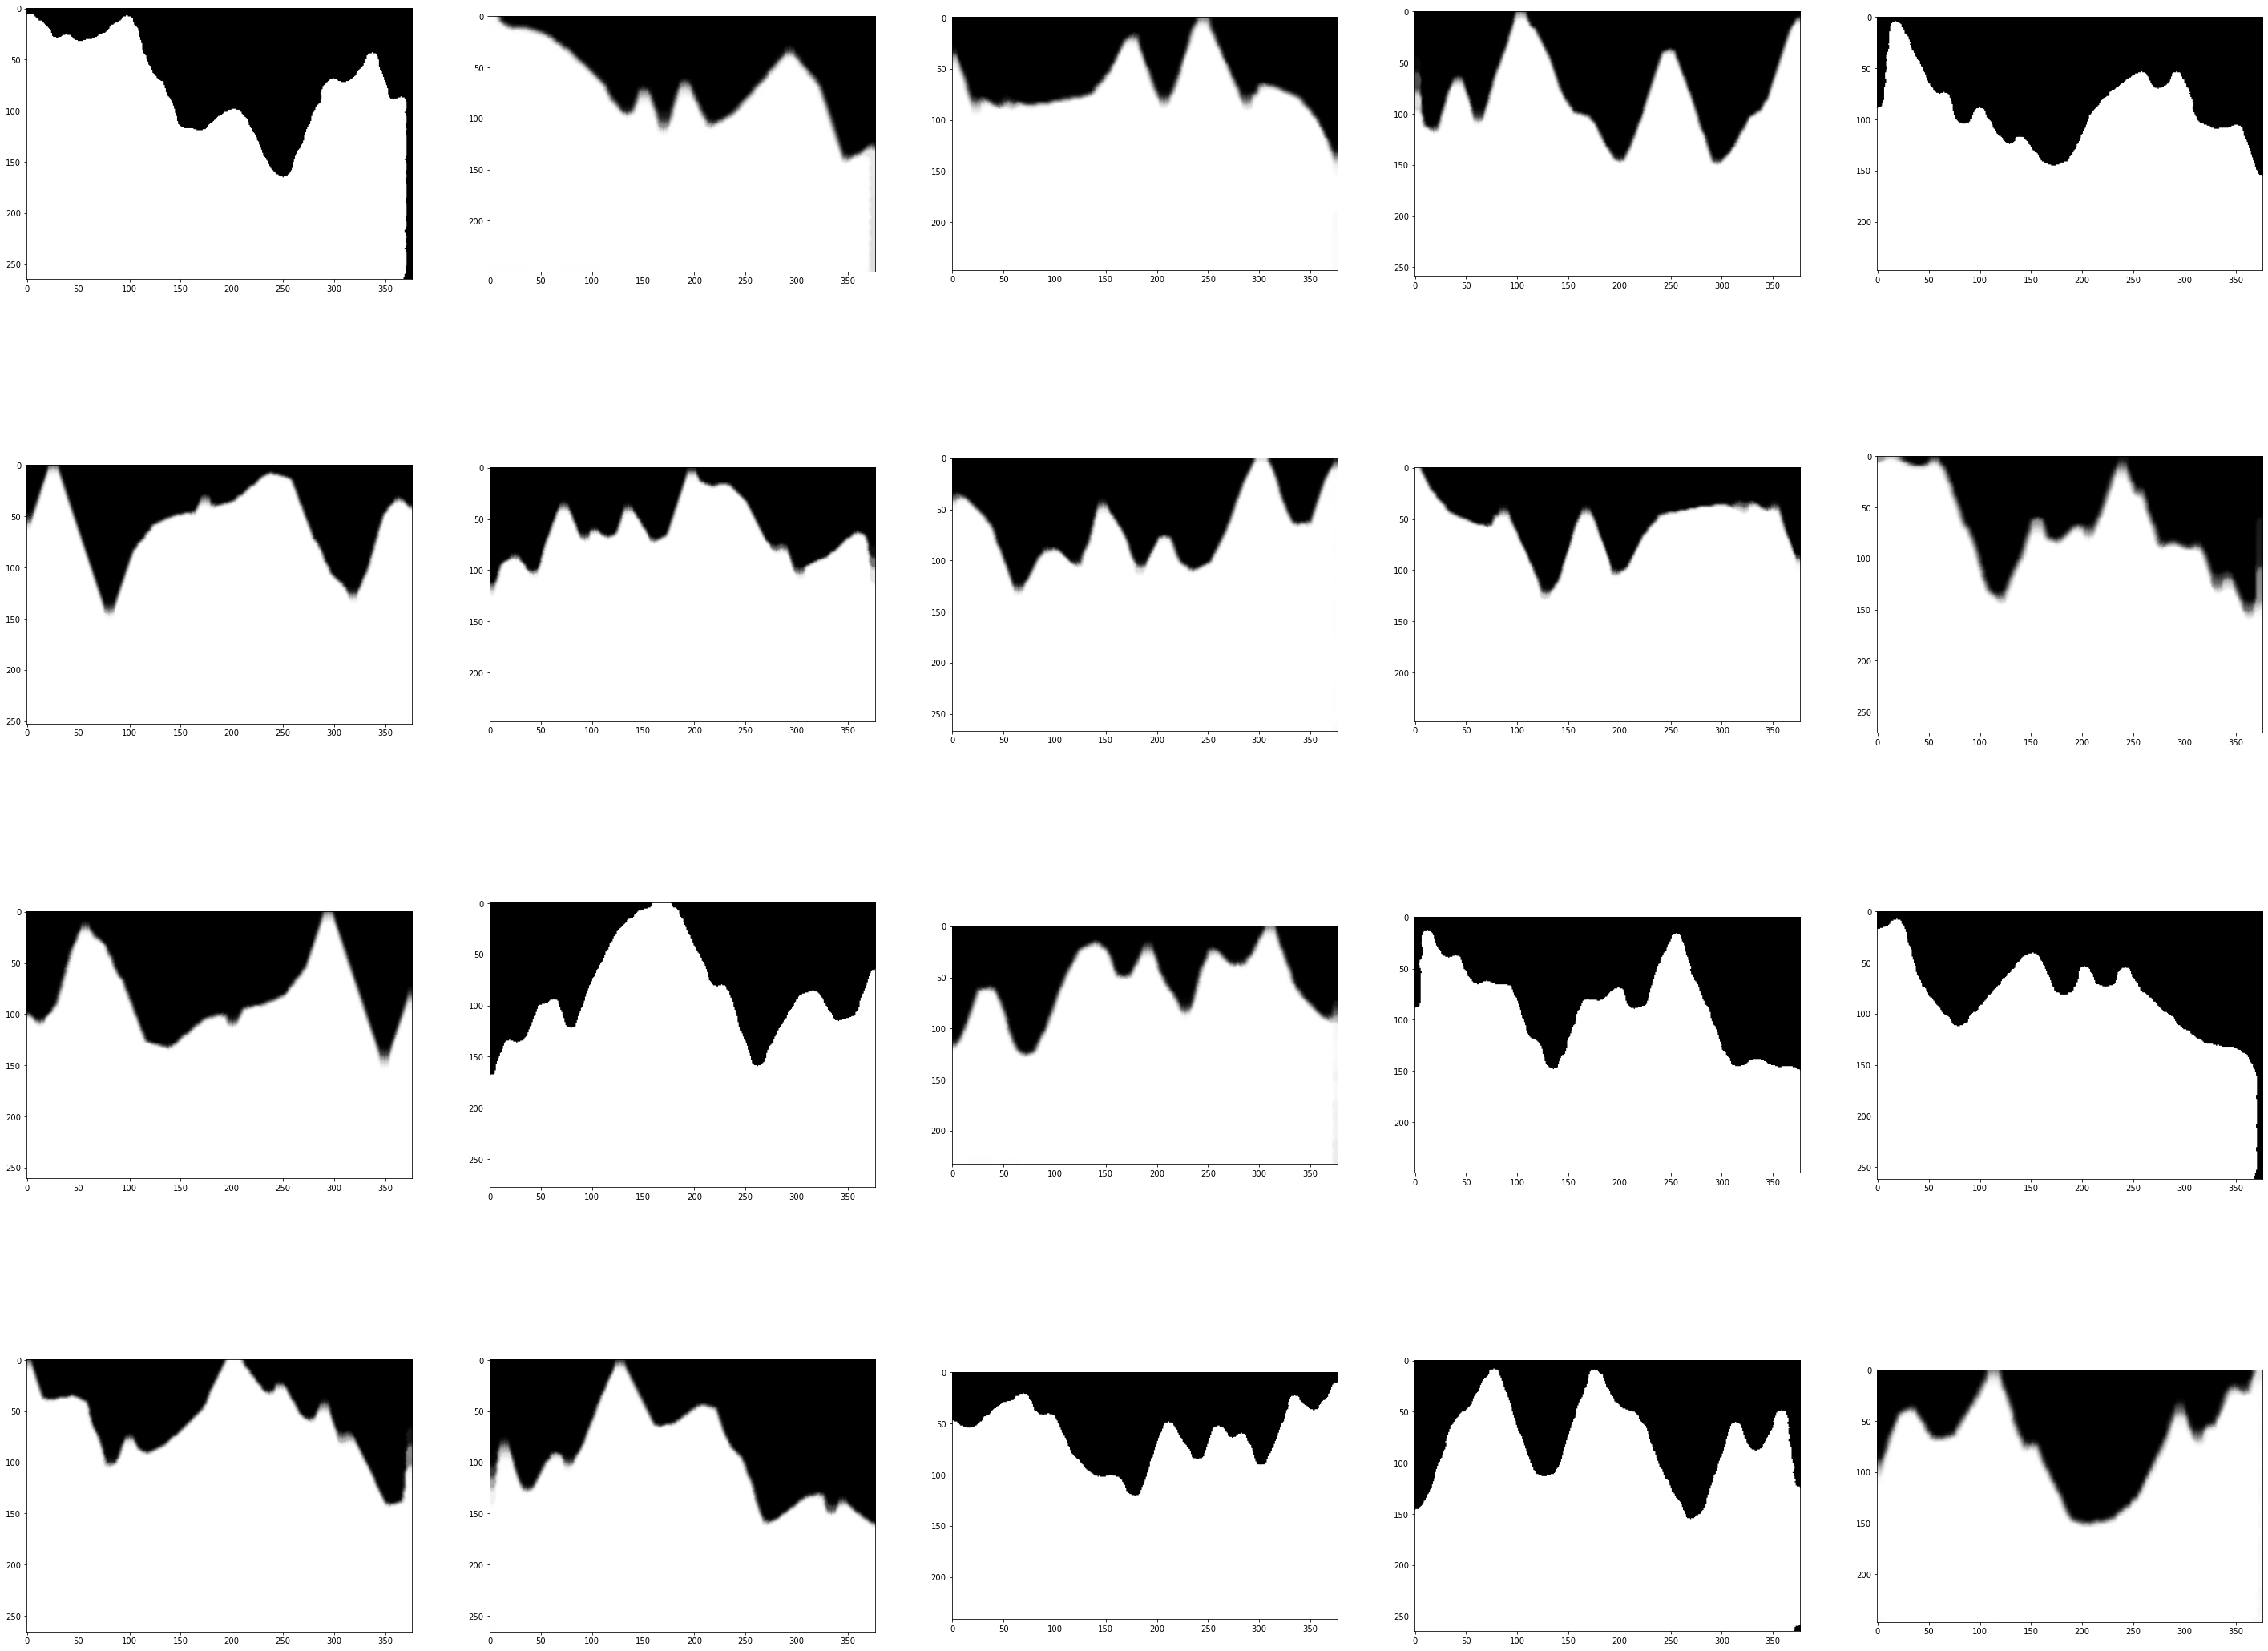

In [706]:
# teścik
n_of_cases = 5
path = os.path.join('D:\Dokumenty\Projekty\PIRO/project1/proj1_daneA\set1', '')
images_paths = glob.glob(os.path.join(path, '*.png'))
images = [io.imread(image_path) for image_path in images_paths]
max_height, max_width = max_height_and_width_from_images(images)
processed_images = list()
test_set = images
for i, image in enumerate(test_set):
    processed_image = rotate_scale_and_cut_image_v4(image, images_paths[i], max_height, max_width)
    processed_images.append(processed_image)
    
fig = plt.figure(figsize=(50,50))
columns = 5
rows = (len(test_set)/columns)+1
for i, img in enumerate(processed_images):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap=plt.cm.gray)


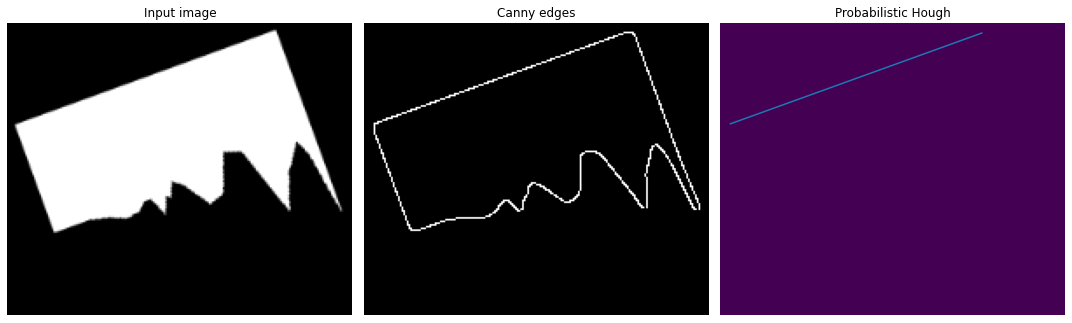

[((6, 58), (150, 6)), ((185, 89), (155, 7)), ((192, 107), (180, 74)), ((192, 104), (188, 94)), ((26, 118), (8, 67)), ((41, 115), (60, 112)), ((18, 97), (6, 63)), ((159, 106), (136, 76)), ((66, 112), (72, 111)), ((86, 106), (91, 105)), ((115, 103), (120, 102)), ((164, 73), (169, 71)), ((162, 103), (162, 82)), ((182, 92), (168, 70)), ((30, 119), (48, 113)), ((78, 104), (83, 102)), ((189, 107), (179, 88)), ((77, 105), (84, 103)), ((190, 107), (183, 94)), ((163, 82), (165, 71)), ((177, 83), (171, 73)), ((8, 68), (6, 61)), ((114, 102), (100, 93)), ((91, 103), (96, 92)), ((148, 92), (133, 74)), ((155, 99), (147, 89)), ((124, 90), (125, 75)), ((124, 96), (124, 91))]
(((6, 58), (150, 6)), 153.1012736720371)


In [28]:
# image = io.imread(images_paths[106])

# edges = canny(image, 2, 1, 25)
# lines = probabilistic_hough_line(edges, threshold=10, line_length=5,
#                                  line_gap=3)
# longest_line = (lines[0],  get_line_length(lines[0][0], lines[0][1]))
# for line in lines:
#     temp_lenght = get_line_length(line[0], line[1])
#     if temp_lenght > longest_line[1]:
#         longest_line = (line, temp_lenght)
# # Generating figure 2
# fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
# ax = axes.ravel()

# ax[0].imshow(image, cmap=cm.gray)
# ax[0].set_title('Input image')

# ax[1].imshow(edges, cmap=cm.gray)
# ax[1].set_title('Canny edges')

# ax[2].imshow(edges * 0)
# # for line in lines:
# p0, p1 = longest_line[0]
# ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))
# ax[2].set_xlim((0, image.shape[1]))
# ax[2].set_ylim((image.shape[0], 0))
# ax[2].set_title('Probabilistic Hough')

# for a in ax:
#     a.set_axis_off()

# plt.tight_layout()
# plt.show()
# print(lines)
# print(longest_line)

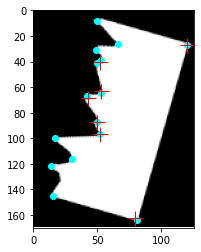

In [502]:
# przykład znajdowania punktów (kątów w sumie nwm)

image = io.imread(images_paths[0])
coords = corner_peaks(corner_harris(image), min_distance=1)
# print(coords)
coords_subpix = corner_subpix(image, coords, window_size=13)
# print(coords_subpix)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, image.shape[1], image.shape[0], 0))
plt.show()


# contours = find_contours(image, level=10)
# image = color.grey2rgb(image)
# print(len(contours))
# print(image.shape)
# for n, contour in enumerate(contours):
#     appr_pol = approximate_polygon(contour, tolerance=5)
#     print(appr_pol)
#     for c in appr_pol:
#         print(c[0], c[1])
#         x,y = circle(int(c[0]),int(c[1]), 2)
#         image[x,y] = [255,0,0]
        
# io.imshow(image)

In [ ]:
##############################################################
####V4

In [634]:
# wersja wycina kawałki na około wykrytych punktów i na tej podstawie szuka katów prostych i podstawy
def rotate_scale_and_cut_image_v4(image, image_path, max_height, max_width):
    points_using_angles_of_lines = get_points_with_right_angle_using_angles_of_lines(image)
    points_using_areas_of_neighborhood = get_points_with_right_angle_using_areas_of_neighborhood(image)

    baseline = get_baseline_using_corners_order(image, image_path)
    if baseline is not None:
        baseline = [(el[1],el[0]) for el in baseline] 
    else:
        print("Nie znaleziono podstawy używając kolejności kątów dla obrazu: {0}".format(image_path))
        baseline = list(points_using_angles_of_lines.intersection(points_using_areas_of_neighborhood))
        baseline = [(el[1],el[0]) for el in baseline]  
    if len(baseline) != 2:
        baseline = None
    if baseline == None:
        print('Nie znaleziono podstawy dla obrazka z użyciem v3: {0}'.format(image_path))
        return rotate_scale_and_cut_image_v1(image, image_path, max_height, max_width) #todo
#         return image
    angle = get_angle_of_line(baseline)
    image = rotate_image(image, angle, baseline)
    image = cut_image_sides(image)
    image = resize_image(image, max_height, max_width)
    image = opening(closing(image, disk(5)), disk(5))
    return image

In [659]:
images_paths

['D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\0.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\1.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\10.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\11.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\12.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\13.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\14.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\15.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\16.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\17.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\18.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\19.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\2.png',
 'D:\\Dokumenty\\Projekty\\PIRO/project1/proj1_daneA\\set1\\3.png',
 'D:\\Dokumenty\\Projekty\\PIRO/projec

angles
[[[203.5        130.        ]
  [ 94.           4.28571429]
  [  4.625       82.        ]]

 [[ 21.          94.78723404]
  [ 30.29411765  93.        ]
  [ 36.         118.87179487]]

 [[ 30.29411765  93.        ]
  [ 36.         118.87179487]
  [ 88.         102.71428571]]

 [[130.         119.79591837]
  [109.10958904 163.        ]
  [118.00904977 167.        ]]

 [[120.         201.95384615]
  [203.5        130.        ]
  [ 94.           4.28571429]]]
right_angles
[[[203.5        130.        ]
  [ 94.           4.28571429]
  [  4.625       82.        ]]

 [[ 30.29411765  93.        ]
  [ 36.         118.87179487]
  [ 88.         102.71428571]]

 [[120.         201.95384615]
  [203.5        130.        ]
  [ 94.           4.28571429]]]
None


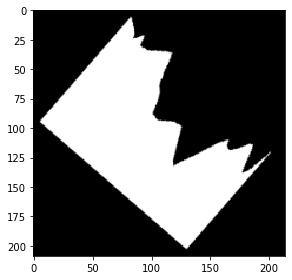

In [708]:
from skimage.segmentation import clear_border
n=0
im = images[n]

def get_baseline_using_corners_order(image, image_path):
    contour = find_contours(image, level=10)[0]
    appr_pol = list(approximate_polygon(contour, tolerance=5)[:-1])
    appr_pol_looped = appr_pol+appr_pol[:2]

    angles = list()
    for p1,p2,p3 in zip(appr_pol_looped[:-2], appr_pol_looped[1:-1], appr_pol_looped[2:]):
        line1 = (p1, p2)
        line2 = (p2, p3)
#         print("=======")
#         print(line1)
#         print(line2)
        if check_if_perpendicular_lines(line1, line2, accuracy_in_degrees=5):
            angles.append(np.array([p1, p2, p3]))
    print("angles")
    print(np.array(angles))
    right_angles = list()
    for angle in angles:
        if check_if_it_is_right_angle_using_areas_of_neighborhood(image, angle[1], radius=30, accuracy=0.02):
            right_angles.append(angle)
    print("right_angles")
    print(np.array(right_angles))
    if len(right_angles) == 2:
        right_angles_in_baseline = right_angles
        baseline = (right_angles_in_baseline[0][1], right_angles_in_baseline[1][1])
        return baseline
    elif len(right_angles) > 2:
        right_angles.append(right_angles[0])
        right_angles_in_baseline = list()
        for p1, p2 in zip(right_angles[:-1], right_angles[1:]):
            for p11, p22 in zip(appr_pol_looped[:-1], appr_pol_looped[1:]):
                if p1[1][0] == p11[0] and p1[1][1] == p11[1] and p2[1][0] == p22[0] and p2[1][1] == p22[1]:
                    right_angles_in_baseline.append(p1)
                    right_angles_in_baseline.append(p2)
        
        if len(right_angles_in_baseline) == 2:
            baseline = (right_angles_in_baseline[0][1], right_angles_in_baseline[1][1])
            return baseline
        else:
#             print("Nie znaleziono podstawy używając kolejności kątów dla obrazu: {0}".format(image_path))
            return None

baseline = get_baseline_using_corners_order(im, 'image_path')
print(baseline)
im = color.gray2rgb(im)
# print(images_paths[n])
# print(len(angles))
# for angle in appr_pol:
#     print(angle)
#     rr, cc = circle(angle[0],angle[1], 3)
#     im[rr, cc] = [255,0,0]
# io.imshow(im)
# for im in images:
#     result = get_baseline_using_corners_order(im, 'image_path')
#     if result is not None:
#         print(result)
io.imshow(im)